# **Implementation of Long-Short Term Memory model**

## **Formating the data**

In [ ]:
# pip install pandas, numpy, scikit-learn, tensorflow, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df_price = pd.read_pickle("hourly.pkl")
df_reserve = pd.read_pickle("reserve_features.pkl")

We filter to keep only what regards bitcoin:

In [3]:
df_btc_price = df_price[df_price['reserve_name'] == 'Wrapped BTC']
df_btc_reserve = df_reserve[df_reserve['reserve_name'] == 'Wrapped BTC']

We merge `df_btc_price` and `df_btc_reserve` on date:

In [4]:
df = pd.merge(df_btc_price, df_btc_reserve, left_on='datetime', right_on='regular_datetime')

We sort by date, remove duplicates et uninteresting variables:

In [5]:
# df = df[(df['datetime'] >= '2023-01-01') & (df['datetime'] < '2024-06-01')]

df = df.sort_values('datetime')
df = df.drop_duplicates(subset='datetime')
cols_to_drop = [
    'Unnamed: 0_x',
    'Unnamed: 0_y',
    'blockNumber',
    'timestamp_hours',
    'snapshot_timestamp',
    'timestamp',
    'outputTokenPriceUSD',
    'totalPrincipalStableDebt',
    'averageStableBorrowRate',
    'priceInEth',
    'priceInUsd',
    'reserve_decimals',
    'true_value',
    'reserve_name_x',
    'reserve_name_y',
    'regular_datetime'
]
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

We define the variables: logarithm of price of bitcoin, and logarithm of `totalATokenSupply`, `totalLiquidity`, `availableLiquidity`:

In [6]:
df['log_BTC'] = np.log(df['inputTokenPriceUSD'])

for col in ['totalATokenSupply', 'totalLiquidity', 'availableLiquidity']:
    if col in df.columns:
        df[f'log_{col}'] = np.log(df[col] + 1e-8) # to avoid log(0)

We also approximate the percent change of each variable $X_t$ as the simple differences on its log-variable, namely $\text{diff\_log\_} X_t := \log(X_t) - \log(X_{t - 1})$.

This approximation is valid because $$\text{diff\_log\_} X_t = \log\left(\frac{X_t}{X_{t - 1}}\right) \approx \frac{X_t}{X_{t - 1}} - 1 = \frac{X_t - X_{t - 1}}{X_{t - 1}}$$ since $\log(u) \approx u - 1$ when $u \approx 1$.

In [7]:
df['diff_log_BTC'] = df['log_BTC'].diff()
df['diff_log_totalATokenSupply'] = df['log_totalATokenSupply'].diff()
df['diff_log_totalLiquidity'] = df['log_totalLiquidity'].diff()
df['diff_log_availableLiquidity'] = df['log_availableLiquidity'].diff()

# Delete first line which contains NaN's because of diff()
df = df.dropna(subset=['diff_log_BTC', 'diff_log_totalATokenSupply', 'diff_log_totalLiquidity', 'diff_log_availableLiquidity'])

df[['diff_log_BTC', 'diff_log_totalATokenSupply', 'diff_log_totalLiquidity', 'diff_log_availableLiquidity']].describe()

,diff_log_BTC,diff_log_totalATokenSupply,diff_log_totalLiquidity,diff_log_availableLiquidity
count,14022.000000,14022.000000,14022.000000,14022.000000
mean,0.000100,0.000783,0.000783,0.000778
std,0.005712,0.022182,0.022184,0.024222
min,-0.060709,-0.529520,-0.529555,-0.657475
25%,-0.001883,-0.000037,-0.000038,-0.000087
50%,0.000000,0.000019,0.000019,0.000026
75%,0.002174,0.000223,0.000222,0.000310
max,0.059685,1.499515,1.499515,1.499515


In [8]:
df = df.dropna(subset=['log_BTC', 'log_totalATokenSupply', 'log_totalLiquidity', 'log_availableLiquidity'])
df = df.reset_index(drop=True)
df[['datetime', 'log_BTC', 'log_totalATokenSupply', 'log_totalLiquidity', 'log_availableLiquidity']].head()

,datetime,log_BTC,log_totalATokenSupply,log_totalLiquidity,log_availableLiquidity
0,2023-01-27 13:00:00+00:00,10.038424,-0.263094,-0.263094,-0.263094
1,2023-01-27 14:00:00+00:00,10.036305,1.236421,1.236421,1.236421
2,2023-01-27 15:00:00+00:00,10.042360,1.660758,1.660758,1.660758
3,2023-01-27 16:00:00+00:00,10.043632,1.671224,1.671224,1.671224
4,2023-01-27 17:00:00+00:00,10.045688,1.660758,1.660758,1.660758


In [9]:
feature_cols = [
    'log_BTC', 'log_totalATokenSupply', 'log_totalLiquidity', 'log_availableLiquidity',
    'diff_log_BTC', 'diff_log_totalATokenSupply', 'diff_log_totalLiquidity', 'diff_log_availableLiquidity'
]
target_col = 'log_BTC'
df_model = df[feature_cols].copy()
df_model

,log_BTC,log_totalATokenSupply,log_totalLiquidity,log_availableLiquidity,diff_log_BTC,diff_log_totalATokenSupply,diff_log_totalLiquidity,diff_log_availableLiquidity
0,10.038424,-0.263094,-0.263094,-0.263094,-0.000530,2.151608e-01,2.151608e-01,2.151608e-01
1,10.036305,1.236421,1.236421,1.236421,-0.002120,1.499515e+00,1.499515e+00,1.499515e+00
2,10.042360,1.660758,1.660758,1.660758,0.006055,4.243365e-01,4.243365e-01,4.243365e-01
3,10.043632,1.671224,1.671224,1.671224,0.001272,1.046650e-02,1.046650e-02,1.046650e-02
4,10.045688,1.660758,1.660758,1.660758,0.002057,-1.046650e-02,-1.046650e-02,-1.046650e-02
...,...,...,...,...,...,...,...,...
14017,11.448489,10.507687,10.505377,10.427871,0.001481,-1.907344e-04,-1.911956e-04,-2.030515e-04
14018,11.448489,10.507601,10.505292,10.427447,0.000000,-8.521763e-05,-8.542323e-05,-4.242535e-04
14019,11.443274,10.507358,10.505048,10.426645,-0.005214,-2.430528e-04,-2.436295e-04,-8.017045e-04
14020,11.445853,10.507359,10.505049,10.426646,0.002579,5.715805e-07,5.458733e-07,5.755779e-07


We split the data chronologically: Train = 70 %, Validation = 15 %, Test = 15 % :

In [10]:
n = len(df_model)
train_size = int(0.70 * n)
val_size = int(0.15 * n)

train_df = df_model.iloc[:train_size]
val_df = df_model.iloc[train_size:train_size+val_size]
test_df = df_model.iloc[train_size+val_size:]

We normalize the features $x$ using the formula
$$x_{\text{standard}} = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}$$

We fit the scaler on the training set and we apply the transformation to the validation and test sets:

In [11]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df)

val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

## **Constructing the sequences**

We create fixed-length sliding windows/sequences:

In [12]:
def create_sequences(data, window=24, horizon=1):
    X, y = [], []
    for i in range(len(data) - window - horizon + 1):
        X.append(data[i:i+window])
        y.append(data[i+window+horizon-1][0]) # 0 = log_BTC
    return np.array(X), np.array(y)

We'll start testing it with a window of size 24 hours and we predict one step ahead (`HORIZON = 1`):

In [13]:
WINDOW = 24
HORIZON = 1

X_train, y_train = create_sequences(train_scaled, WINDOW, HORIZON)
X_val, y_val = create_sequences(val_scaled, WINDOW, HORIZON)
X_test, y_test = create_sequences(test_scaled, WINDOW, HORIZON)

X_train.shape, y_train.shape

((9791, 24, 8), (9791,))

## **Constructing the LSTM model**

In [14]:
input_shape = X_train.shape[1:] # (24, 4)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dense(1) # predicts log_BTC at time t+1
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

## **Training the model**

We create an 'early stopping callback' which stops training if `val_loss` no longer improves. Then we train the model:

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0893 - root_mean_squared_error: 0.2681 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 8.4678e-04 - val_root_mean_squared_error: 0.0291
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 4.5184e-04 - val_root_mean_squared_error: 0.0213
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 3.0060e-04 - val_root_mean_squared_error: 0.0173
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 5.6557e-04 - val_root_mean_squared_error: 0.0238
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 6.5697e-04 - val_root_mean_squared_error: 0.0256
Epoch 7/50
153/153 ━━━━━━

## **Evaluating the model**

We predict `log_BTC` at time $t + 1$. We add dummy columns to match the original feature shape. Finally, we invert the scaler to return to original scale.

In [16]:
y_pred_scaled = model.predict(X_test).flatten()

n_features = X_test.shape[2]
y_pred_full = np.column_stack([y_pred_scaled] + [np.zeros_like(y_pred_scaled) for _ in range(n_features - 1)])
y_true_full = np.column_stack([y_test] + [np.zeros_like(y_test) for _ in range(n_features - 1)])

y_pred_inversed = scaler.inverse_transform(y_pred_full)[:, 0]
y_true_inversed = scaler.inverse_transform(y_true_full)[:, 0]

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [17]:
rmse = np.sqrt(mean_squared_error(y_true_inversed, y_pred_inversed))
mae = mean_absolute_error(y_true_inversed, y_pred_inversed)
r2 = r2_score(y_true_inversed, y_pred_inversed)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² : {r2:.4f}")

RMSE: 0.1020
MAE: 0.0784
R² : 0.6811


Below we compare the true log-price of bitcoin with the 200 first predictions:

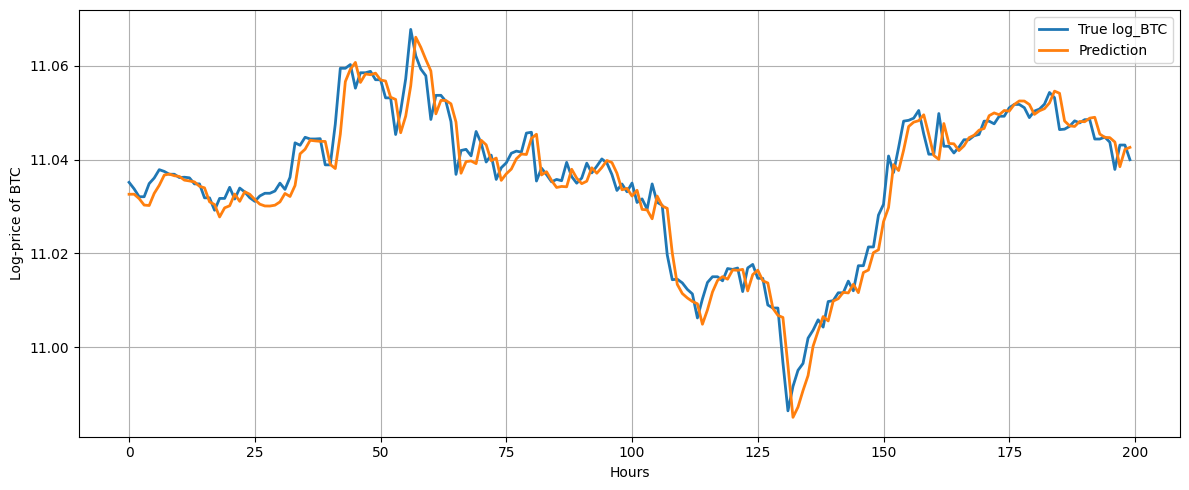

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_inversed[:200], label="True log_BTC", linewidth=2)
plt.plot(y_pred_inversed[:200], label="Prediction", linewidth=2)
plt.xlabel("Hours")
plt.ylabel("Log-price of BTC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We compare true log-bictoin with prediction on the whole test set:

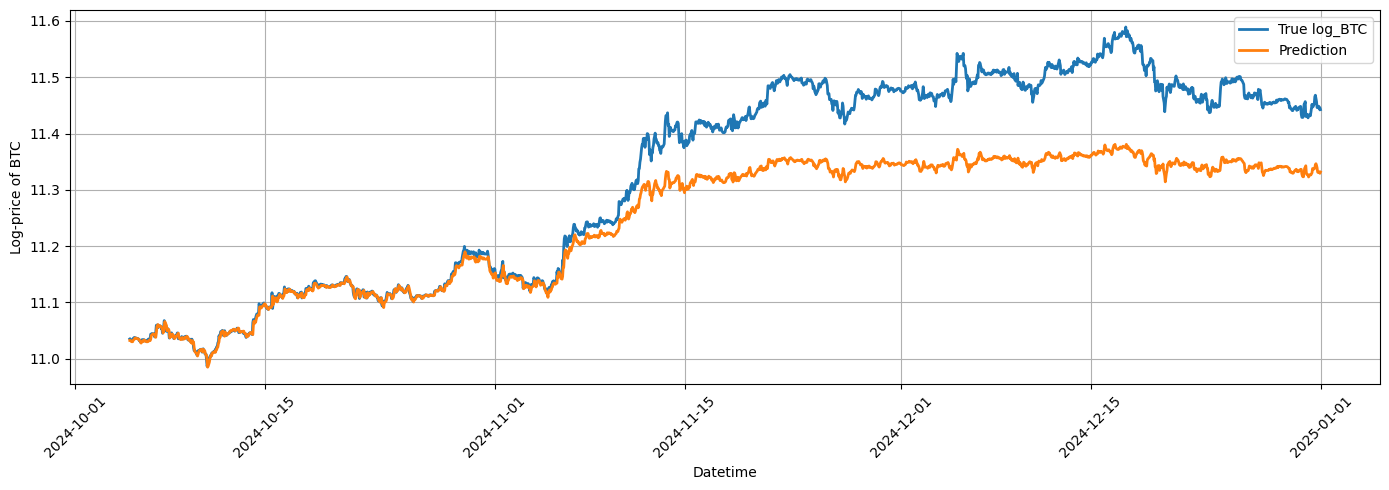

In [19]:
test_datetime = df['datetime'].iloc[train_size + val_size + WINDOW + HORIZON - 1 :
                                    train_size + val_size + WINDOW + HORIZON - 1 + len(y_true_inversed)]

plt.figure(figsize=(14, 5))
plt.plot(test_datetime, y_true_inversed, label="True log_BTC", linewidth=2)
plt.plot(test_datetime, y_pred_inversed, label="Prediction", linewidth=2)
plt.xlabel("Datetime")
plt.ylabel("Log-price of BTC")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Trying other lenghts of windows**

In [20]:
for window in [8, 10, 12, 14, 16, 24, 48, 72]:
    print(f"\n---> Testing window of length {window} hours.")

    X_train, y_train = create_sequences(train_scaled, window)
    X_val, y_val = create_sequences(val_scaled, window)
    X_test, y_test = create_sequences(test_scaled, window)

    model = models.Sequential([
        layers.Input(shape=(window, X_train.shape[2])),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    es = callbacks.EarlyStopping(patience=5,
                                 restore_best_weights=True,
                                 monitor='val_loss')

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=50,
              batch_size=64,
              callbacks=[es],
              verbose=0)

    y_pred_scaled = model.predict(X_test, verbose=0).flatten()

    n_features = X_test.shape[2]
    y_pred_full = np.column_stack([y_pred_scaled] + [np.zeros_like(y_pred_scaled) for _ in range(n_features - 1)])
    y_true_full = np.column_stack([y_test] + [np.zeros_like(y_test) for _ in range(n_features - 1)])
    y_pred_inversed = scaler.inverse_transform(y_pred_full)[:, 0]
    y_true_inversed = scaler.inverse_transform(y_true_full)[:, 0]

    rmse = np.sqrt(mean_squared_error(y_true_inversed, y_pred_inversed))
    mae = mean_absolute_error(y_true_inversed, y_pred_inversed)
    r2 = r2_score(y_true_inversed, y_pred_inversed)

    print(f"window of {window} hours --- RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")


---> Testing window of length 8 hours.
window of 8 hours --- RMSE = 0.0840, MAE = 0.0650, R² = 0.7863

---> Testing window of length 10 hours.
window of 10 hours --- RMSE = 0.0844, MAE = 0.0647, R² = 0.7840

---> Testing window of length 12 hours.
window of 12 hours --- RMSE = 0.1073, MAE = 0.0832, R² = 0.6501

---> Testing window of length 14 hours.
window of 14 hours --- RMSE = 0.1043, MAE = 0.0790, R² = 0.6691

---> Testing window of length 16 hours.
window of 16 hours --- RMSE = 0.1192, MAE = 0.0928, R² = 0.5669

---> Testing window of length 24 hours.
window of 24 hours --- RMSE = 0.1008, MAE = 0.0779, R² = 0.6882

---> Testing window of length 48 hours.
window of 48 hours --- RMSE = 0.1294, MAE = 0.0996, R² = 0.4766

---> Testing window of length 72 hours.
window of 72 hours --- RMSE = 0.1724, MAE = 0.1342, R² = 0.0524
